In [1]:
from scipy.stats import vonmises
from subprocess import call
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import re
import shutil
import sys
import time
%config Completer.use_jedi = False

In [4]:
sys.argv = ["python","1","56683","1"]
if not os.path.exists(f"__simcache__/{sys.argv[1]}_{sys.argv[2]}_{sys.argv[3]}"):
    os.makedirs(f"__simcache__/{sys.argv[1]}_{sys.argv[2]}_{sys.argv[3]}")
else:
    shutil.rmtree(f"__simcache__/{sys.argv[1]}_{sys.argv[2]}_{sys.argv[3]}")
    os.makedirs(f"__simcache__/{sys.argv[1]}_{sys.argv[2]}_{sys.argv[3]}")

In [26]:
n_n = 120             # number of neurons
p_n = 90                  # number of PNs
l_n = 30                  # number of LNs

pPNPN = 0.0
pPNLN = 0.1
pLNPN = 0.2

ach_mat = np.zeros((n_n,n_n))
np.random.seed(64163+int(sys.argv[1]))
ach_mat[p_n:,:p_n] = np.random.choice([0.,1.],size=(l_n,p_n),p=(1-pPNLN,pPNLN))
ach_mat[:p_n,:p_n] = np.random.choice([0.,1.],size=(p_n,p_n),p=(1-pPNPN,pPNPN))
n_syn_ach = int(np.sum(ach_mat))

LNPN = np.zeros((p_n,l_n))
stride = int(p_n/l_n)
spread = (round(pLNPN*p_n)//2)*2+1 # Round to closest odd integer
center = 0
index = np.arange(p_n)
for i in range(l_n):
    idx = index[np.arange(center-spread//2,1+center+spread//2)%p_n]
    LNPN[idx,i] = 1
    center+=stride

fgaba_mat = np.zeros((n_n,n_n))
fgaba_mat[:p_n,p_n:] = LNPN # LN->PN
fgaba_mat[p_n:,p_n:] = np.loadtxt(f'../modules/networks/matrix_{sys.argv[1]}.csv',delimiter=',') # LN->LN
np.fill_diagonal(fgaba_mat,0.)
n_syn_fgaba = int(np.sum(fgaba_mat))

sgaba_mat = np.zeros((n_n,n_n))
sgaba_mat[:p_n,p_n:] = LNPN
np.fill_diagonal(sgaba_mat,0.)
n_syn_sgaba = int(np.sum(sgaba_mat))

In [27]:
blocktime = 1000 # in ms
buffer = 500 # in ms
sim_res = 0.01 # in ms
min_block = 50 # in ms

In [45]:
np.random.seed(int(sys.argv[2]))
v=[]
for i in range(6):
    v.append(np.concatenate([np.random.choice([0,1],p=[0.9,0.1],size=90),[0]*30]))
v = np.array(v)
width = int(blocktime/sim_res)
tfilter_base = np.ones(width)
width_red = int(1*blocktime/sim_res)
tfilter = np.zeros_like(tfilter_base)
tfilter[:width_red] = 1

In [46]:
sim_time = len(v)*blocktime + 2*buffer
t = np.arange(0,sim_time,sim_res)
current_input = np.ones((n_n,t.shape[0]-int(2*buffer/sim_res)))
for i in range(len(v)):
    current_input[p_n:,i*width:(i+1)*width]=0.0735*current_input[p_n:,i*width:(i+1)*width]*tfilter_base
    current_input[:p_n,i*width:(i+1)*width]+= 0.20*(current_input[:p_n,i*width:(i+1)*width].T*v[i][:p_n]).T*tfilter - current_input[:p_n,i*width:(i+1)*width]
current_input = np.concatenate([np.zeros((current_input.shape[0],int(buffer/sim_res))),current_input,np.zeros((current_input.shape[0],int(buffer/sim_res)))],axis=1)
current_input += 0.05*current_input*np.random.normal(size=current_input.shape)+ 0.001*np.random.normal(size=current_input.shape)

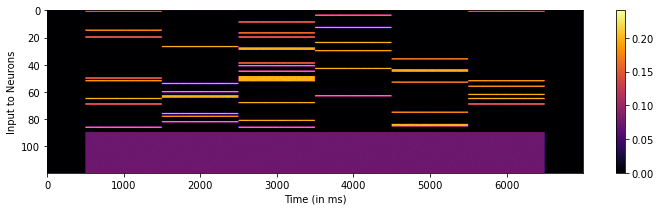

In [47]:
plt.figure(figsize=(12,3))
plt.imshow(current_input[:,::100],aspect='auto',vmin=0,cmap=plt.cm.inferno)
plt.xlabel('Time (in ms)')
plt.ylabel('Input to Neurons')
plt.colorbar()

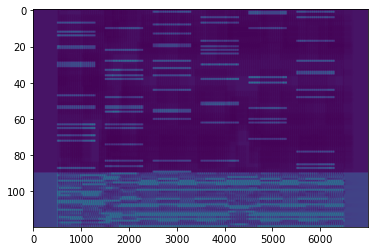

In [51]:
plt.imshow(np.load("data_1_55392_1.npy").T,aspect='auto')

In [7]:
data = []
time = np.linspace(0,6.998,6999)
for i in tqdm(range(5)):
    temp = np.load(f"Data/data_1_59428_{i+1}.npy")
    pn_temp = np.logical_and(temp[:-1,:90]<0,temp[1:,:90]>0)
    ln_temp = np.logical_and(temp[:-1,90:]<-20,temp[1:,90:]>-20)
    pn_firing = []
    ln_firing = []
    for j in range(90):
        pn_firing.append(time[pn_temp[:,j]])
    for j in range(30):
        ln_firing.append(time[ln_temp[:,j]])
    data.append((pn_firing,ln_firing,temp))

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 122.18it/s]


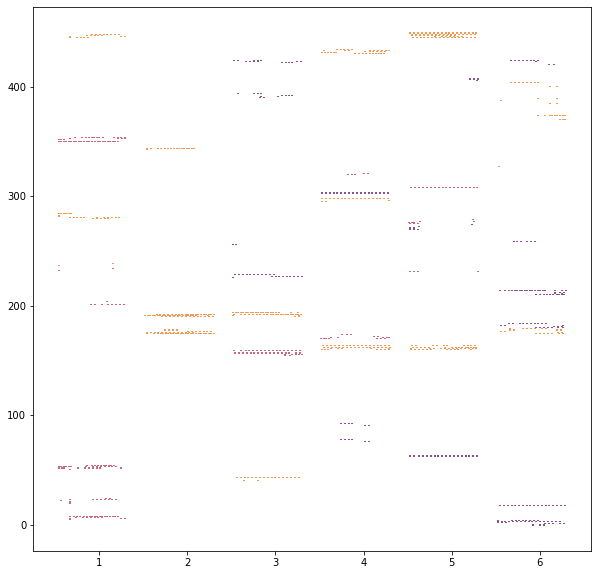

In [11]:
rep = 5
plt.figure(figsize=(10,10))
events = []
colors = []
for i in range(90):
    for j in range(rep):
        events.append(data[j][0][i])
colors = ([plt.cm.inferno(0.3)]*rep+[plt.cm.inferno(0.5)]*rep+[plt.cm.inferno(0.7)]*rep)*30
plt.eventplot(events,colors=colors)
plt.show()